# General Information about the Data
The dataset simulates high-energy gamma particle registration in a ground-based atmospheric Cherenkov gamma telescope using imaging techniques. Cherenkov telescopes observe gamma rays by detecting radiation emitted by charged particles from electromagnetic showers initiated by gammas in the atmosphere. The Cherenkov radiation, in the visible to UV range, passes through the atmosphere and is recorded by photomultiplier tubes in the telescope's camera, allowing reconstruction of shower parameters.

The shower images are elongated clusters, with their long axis oriented towards the camera center if the telescope's optical axis is aligned with the shower axis. Principal component analysis in the camera plane defines an ellipse (Hillas parameters) used for discrimination between gamma-induced (signal) and cosmic ray-induced (background) showers. Image parameters, such as cluster extent, total energy deposition, and asymmetry along the major axis, provide additional discrimination features.

The dataset, containing 19,020 instances, was generated by the Monte Carlo program CORSIKA, simulating events with energies as low as 50 GeV.

In [33]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from keras import Sequential
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ( confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,auc)
from sklearn.linear_model import LogisticRegression
from typing import List, Dict,Tuple
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from xgboost import XGBClassifier
from sklearn.decomposition import PCA


In [34]:
data:pd.DataFrame = pd.read_csv("telescope_data.csv")

In [35]:
data.head()

,Unnamed: 0,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


1. **fLength**:  
   - **Type**: Continuous  
   - **Description**: Major axis of ellipse [mm]

2. **fWidth**:  
   - **Type**: Continuous  
   - **Description**: Minor axis of ellipse [mm]

3. **fSize**:  
   - **Type**: Continuous  
   - **Description**: 10-log of sum of content of all pixels [#phot]

4. **fConc**:  
   - **Type**: Continuous  
   - **Description**: Ratio of sum of two highest pixels over fSize [ratio]

5. **fConc1**:  
   - **Type**: Continuous  
   - **Description**: Ratio of highest pixel over fSize [ratio]

6. **fAsym**:  
   - **Type**: Continuous  
   - **Description**: Distance from highest pixel to center, projected onto major axis [mm]

7. **fM3Long**:  
   - **Type**: Continuous  
   - **Description**: 3rd root of third moment along major axis [mm]

8. **fM3Trans**:  
   - **Type**: Continuous  
   - **Description**: 3rd root of third moment along minor axis [mm]

9. **fAlpha**:  
   - **Type**: Continuous  
   - **Description**: Angle of major axis with vector to origin [deg]

10. **fDist**:  
    - **Type**: Continuous  
    - **Description**: Distance from origin to center of ellipse [mm]

11. **Class**:  
    - **Type**: Categorical (g, h)  
    - **Description**: Gamma (signal) or Hadron (background)


In [36]:
def clean_column_names (col_name:str) -> str:
    return re.sub(r'^f', '', col_name)

def to_int (col:str) -> int:
    return 1 if col == 'g' else 0

def mm_to_m(col:float)->float:
    return col/1000

def deg_to_rad(col:float)->float:
    return col*np.pi/180

### Functions

#### `clean_column_names(col_name: str) -> str`
Removes the prefix 'f' from the beginning of a column name.

- **Parameters**:
  - `col_name` (str): The original column name.
- **Returns**:
  - `str`: The cleaned column name without the 'f' prefix.

#### `to_int(col: str) -> int`
Converts class labels to integers.

- **Parameters**:
  - `col` (str): The class label, either 'g' (gamma) or 'h' (hadron).
- **Returns**:
  - `int`: Returns `1` for 'g' and `0` for 'h'.

#### `mm_to_m(col: float) -> float`
Converts millimeters to meters.

- **Parameters**:
  - `col` (float): The value in millimeters.
- **Returns**:
  - `float`: The value converted to meters.

#### `deg_to_rad(col: float) -> float`
Converts degrees to radians.

- **Parameters**:
  - `col` (float): The value in degrees.
- **Returns**:
  - `float`: The value converted to radians.

In [37]:
data.rename(columns={col: clean_column_names(col) for col in data.columns}, inplace=True)

data.rename(columns={"class": "Class"}, inplace=True)

data.drop("Unnamed: 0", axis=1, inplace=True)

data.Class = data.Class.apply(to_int)

data[["Length","Width","M3Long","M3Trans","Dist","Asym"]]=data[["Length","Width","M3Long","M3Trans","Dist","Asym"]].apply(mm_to_m)

data[["Alpha"]]=data[["Alpha"]].apply(deg_to_rad)

### Data Preprocessing Steps

1. **Rename Columns**:
   - The columns of the dataset are renamed by removing the 'f' prefix.
   - The `"class"` column is specifically renamed to `"Class"` for consistency.
2. **Drop Unnecessary Column**:
    - The column "Unnamed: 0" is removed from the dataset as it isan index.
3. **Convert Class Labels to Integers**:
   - The "Class" column values are converted from categorical labels ('g' and 'h') to integers (1 for 'g' and 0 for 'h').
4. **Convert Units**:
   - Columns related to distance ("Length", "Width", "M3Long", "M3Trans", "Dist", and "Asym") are converted from millimeters to meters.
   - The "Alpha" column is converted from degrees to radians.

KeyboardInterrupt: 

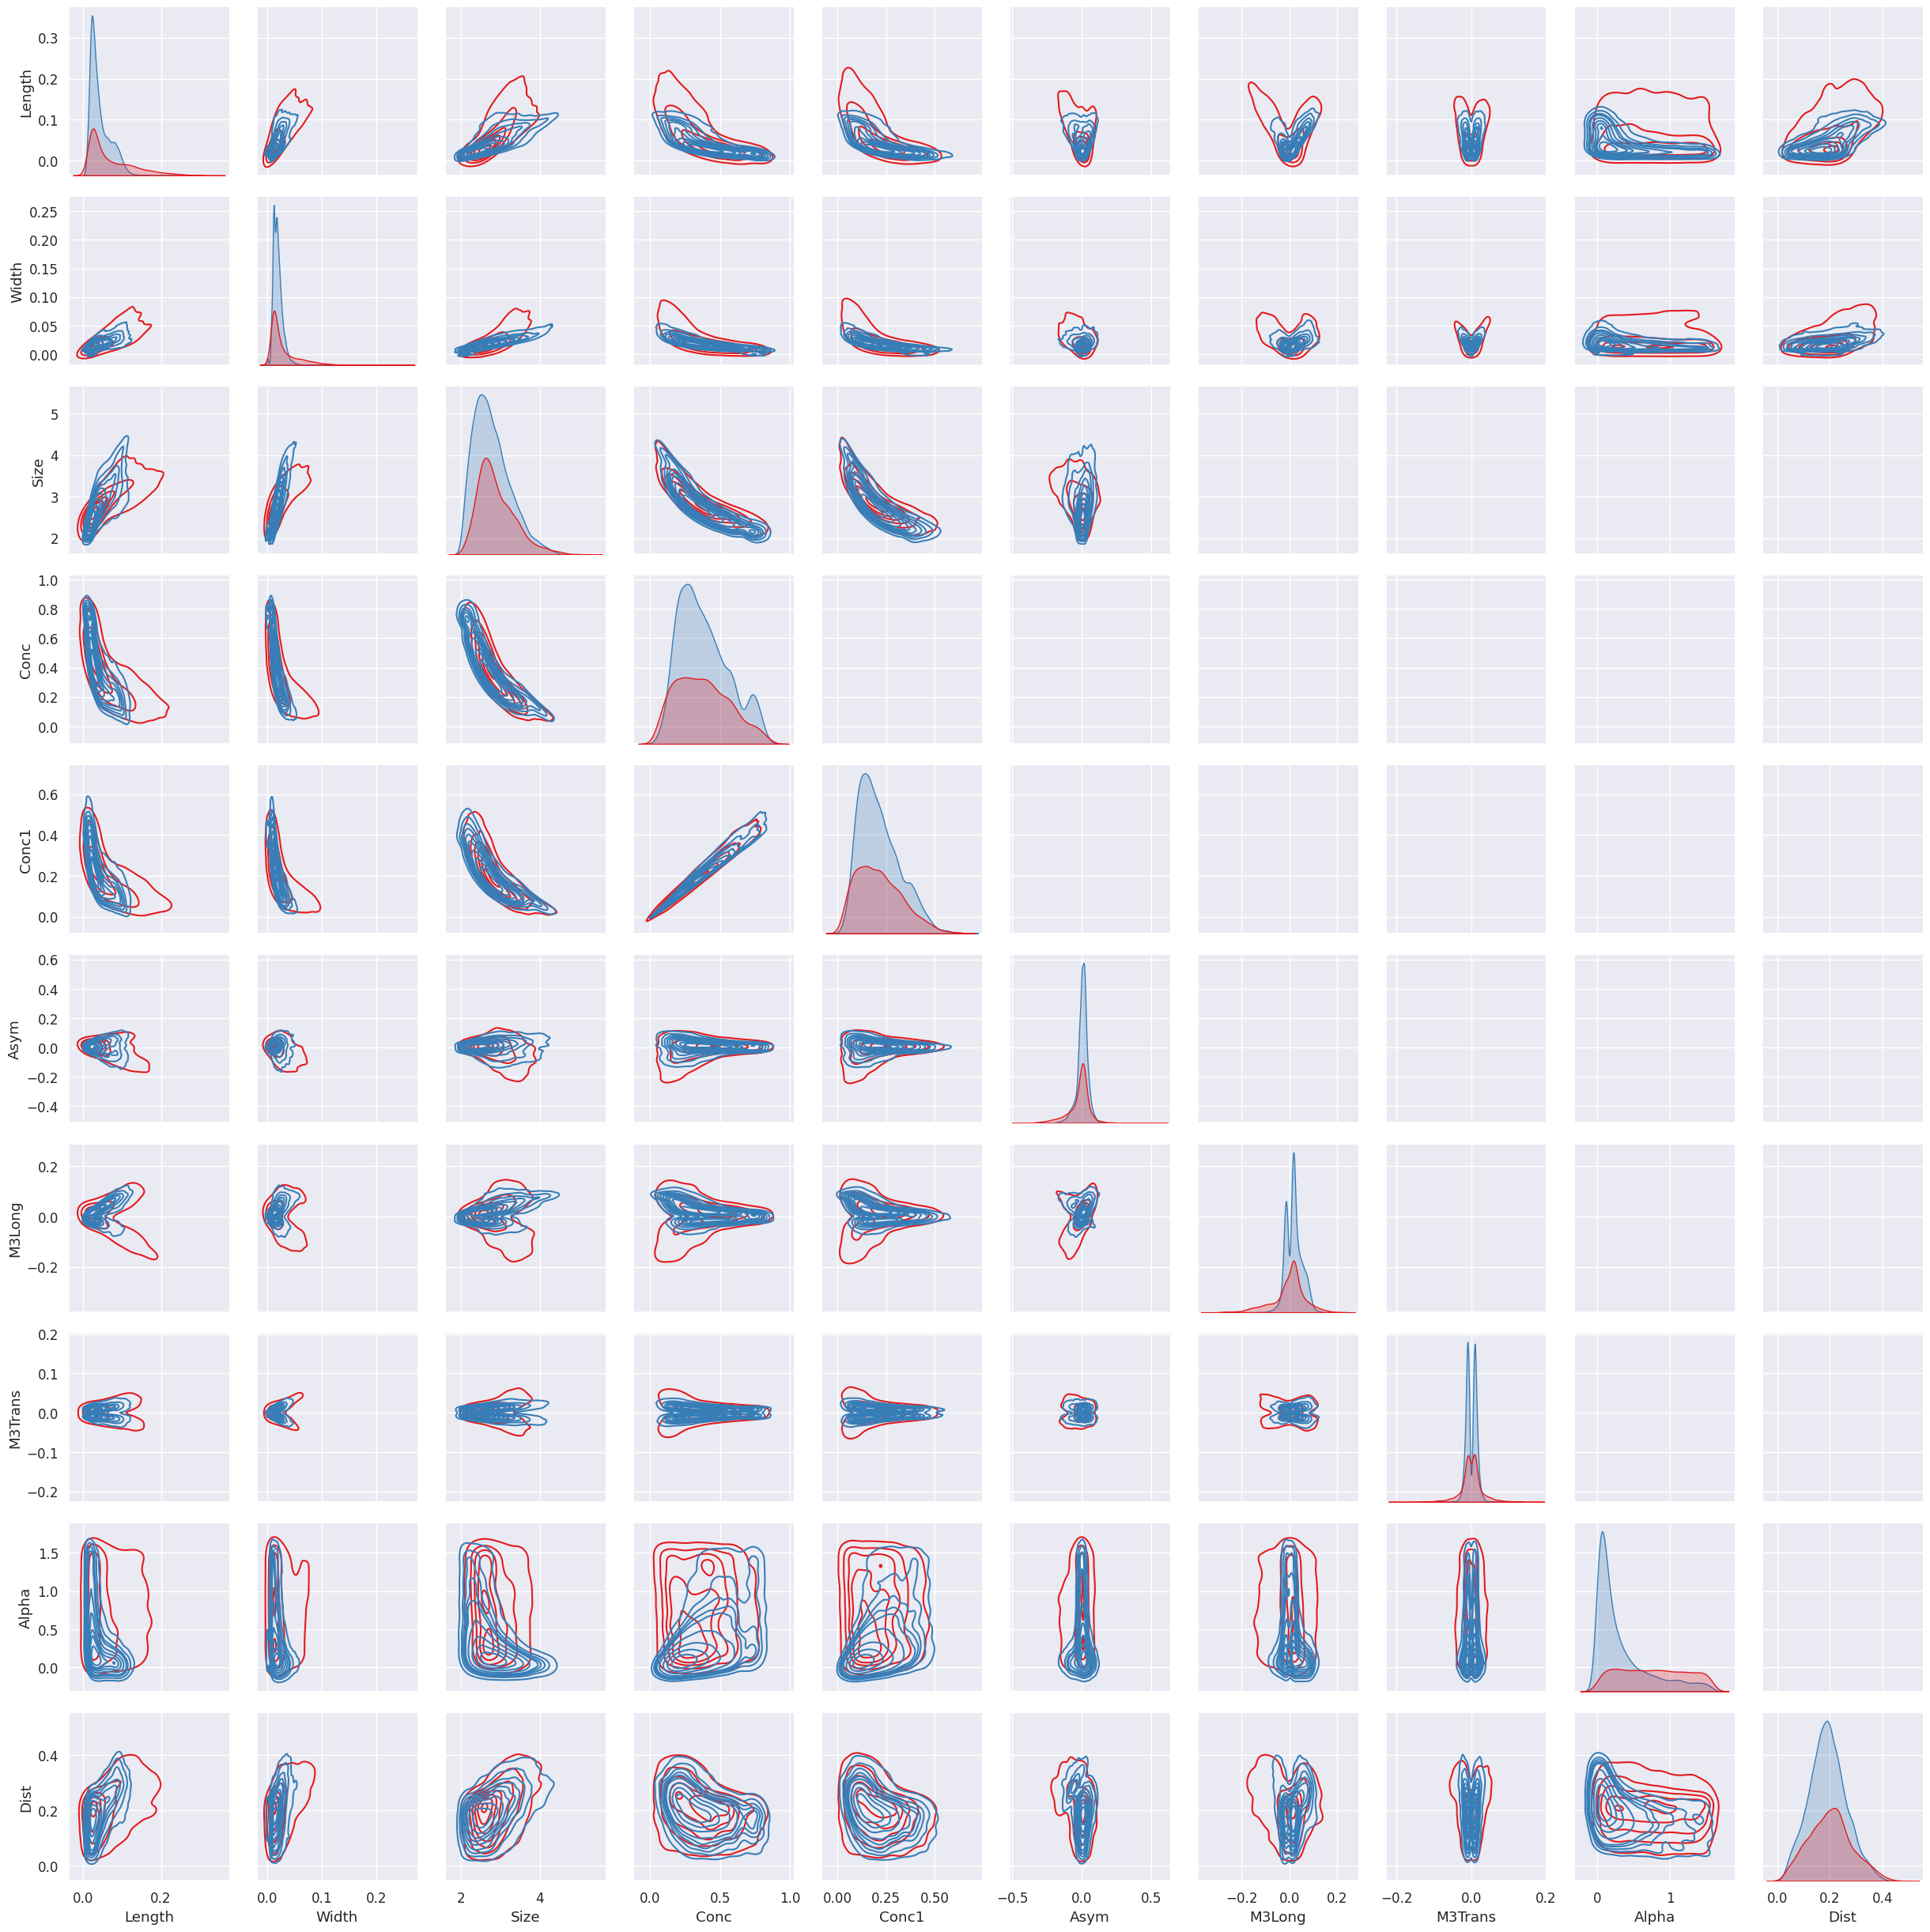

In [38]:
sns.pairplot(data, hue="Class", kind="kde", palette="Set1")
plt.show()

### Data Visualization: Pair Plot

- **Purpose**: 
  - The code generates a pair plot to visualize the relationships between features in the dataset, with the data points colored by class (`"Class"`).
  - The plot type is set to Kernel Density Estimation (KDE) for a smooth distribution representation.


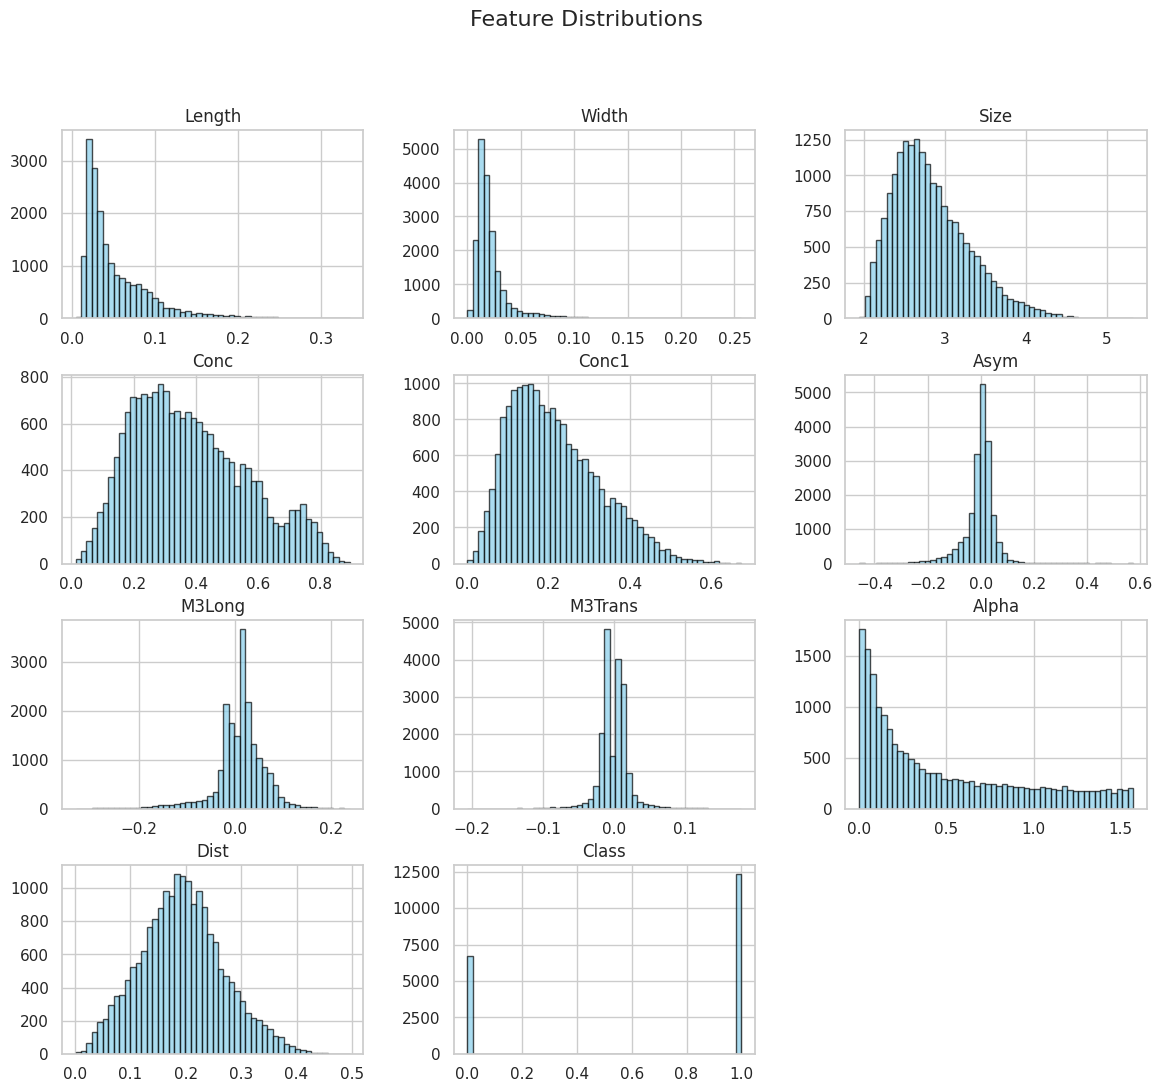

In [7]:
sns.set(style="whitegrid")
data.hist(figsize=(14, 12), bins=50, edgecolor="black", color="skyblue", alpha=0.7)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

### Data Visualization: Feature Distributions

- **Purpose**: 
  - The code generates histograms for each feature in the dataset to visualize their distributions.


Text(0.5, 1.0, 'Correlation Heatmap')

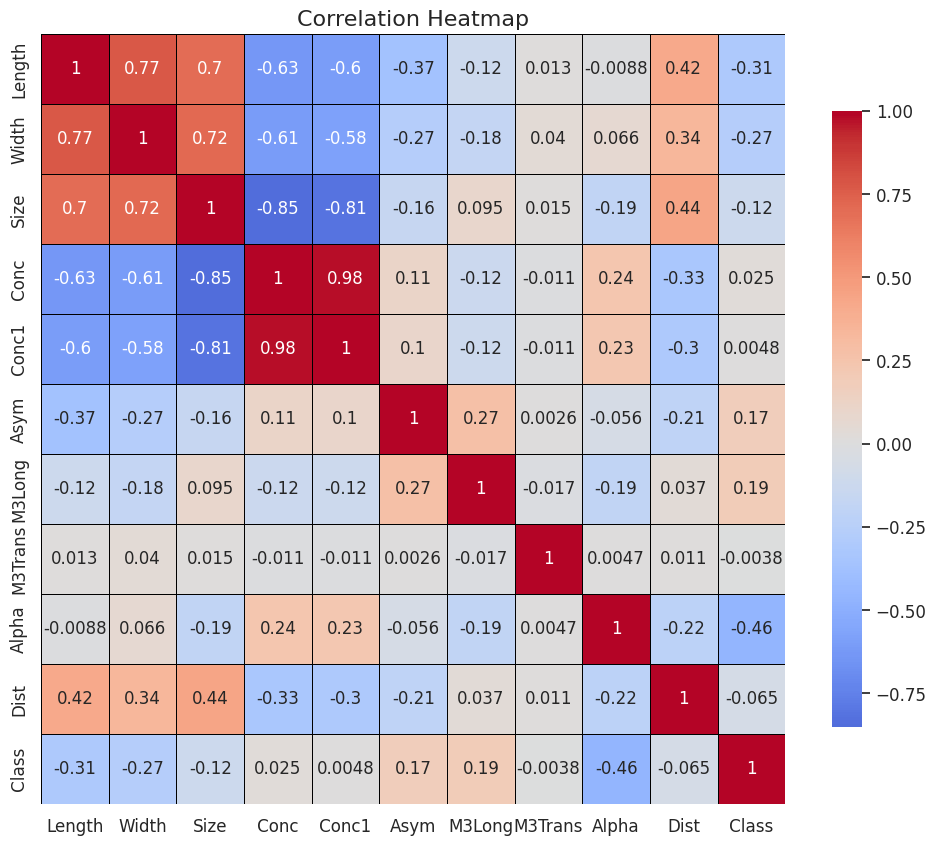

In [8]:
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.1)
correlation_matrix:pd.DataFrame = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm",
            center=0, linewidths=0.5, linecolor="black",
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 12})
plt.title("Correlation Heatmap", fontsize=16)

### Data Visualization: Correlation Heatmap

- **Purpose**: 
  - The code generates a heatmap to visualize the correlation matrix of the dataset, showing the relationships between different features.

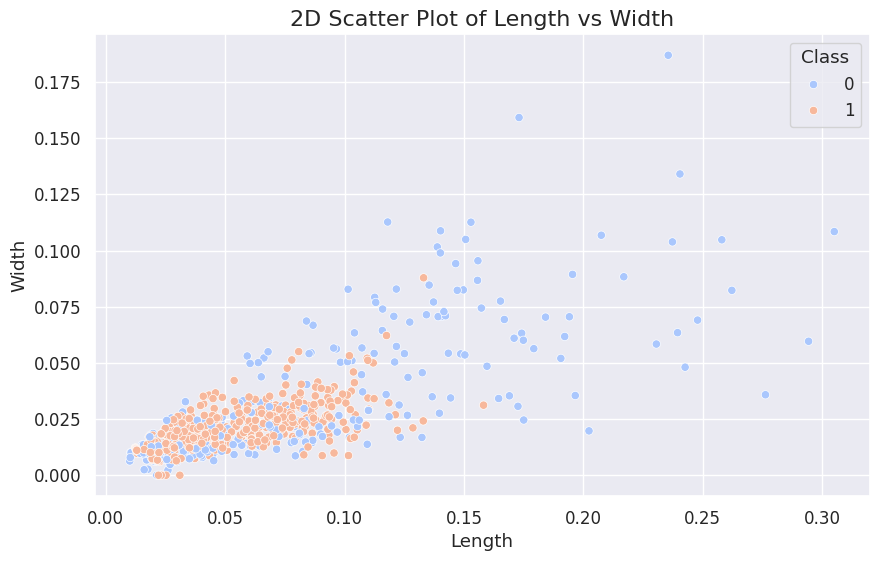

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Length", y="Width", hue="Class", data=data.sample(1000), palette="coolwarm")
plt.title("2D Scatter Plot of Length vs Width", fontsize=16)
plt.show()

### Data Visualization: 2D Scatter Plot of Length vs. Width

- **Purpose**: 
  - The code generates a 2D scatter plot to visualize the relationship between the `"Length"` and `"Width"` features in the dataset, with points colored by class.


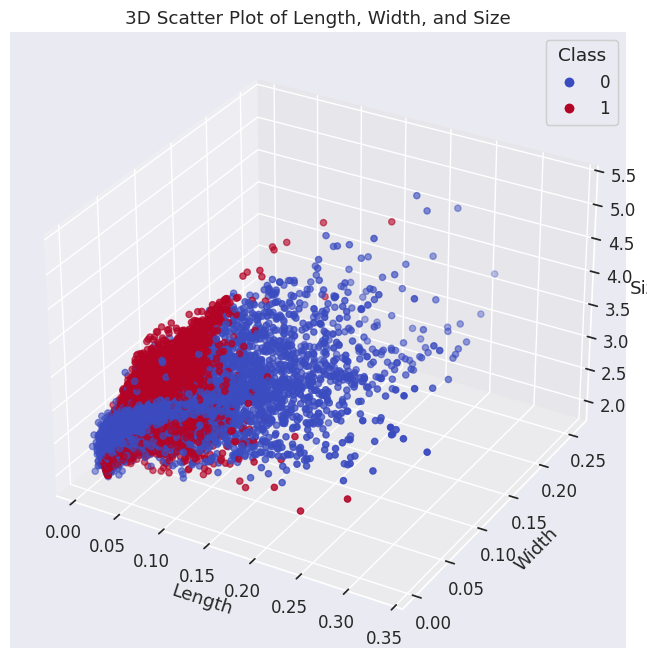

In [10]:
fig:plt.Figure = plt.figure(figsize=(10, 8))
ax:plt.Axes = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(data.Length, data.Width, data.Size, c=data.Class, cmap="coolwarm")
legend1 = ax.legend(*scatter.legend_elements(), title="Class")
ax.add_artist(legend1)
ax.set_xlabel("Length")
ax.set_ylabel("Width")
ax.set_zlabel("Size")
plt.title("3D Scatter Plot of Length, Width, and Size")
plt.show()

### Data Visualization: 3D Scatter Plot of Length, Width, and Size

- **Purpose**: 
  - The code generates a 3D scatter plot to visualize the relationships between the `"Length"`, `"Width"`, and `"Size"` features in the dataset, with points colored by class.


In [11]:
x:pd.DataFrame = data.drop("Class", axis=1)
y:pd.DataFrame = data.Class

### Data Preparation: Feature and Target Separation

- **Purpose**: 
  - The code separates the dataset into features (`X`) and the target variable (`y`) in preparation for machine learning model training.


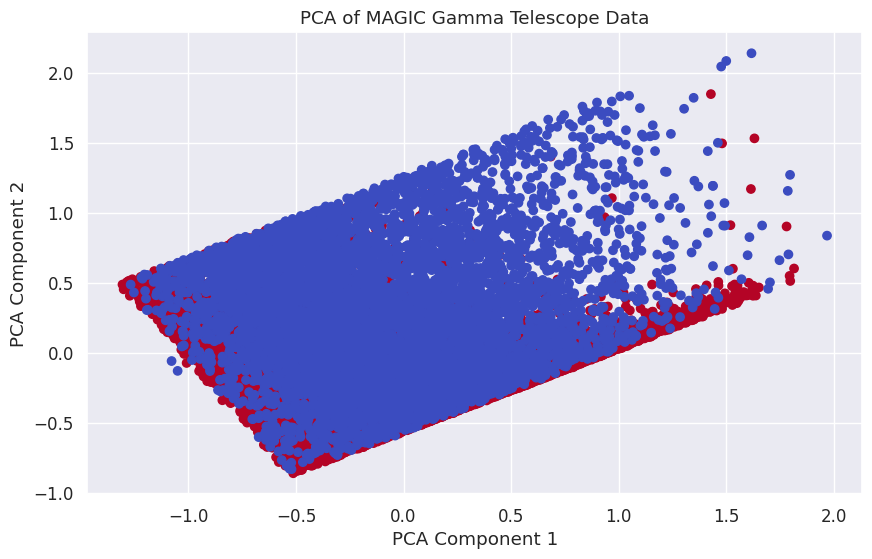

In [12]:
pca:PCA = PCA(n_components=2)
pca_result:np.ndarray = pca.fit_transform(x)
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of MAGIC Gamma Telescope Data")
plt.show()

### Dimensionality Reduction and Visualization: PCA

- **Purpose**: 
  - The code performs Principal Component Analysis (PCA) to reduce the dimensionality of the feature set to 2 components and visualizes the result with a scatter plot.


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Data Splitting: Train-Test Split

- **Purpose**: 
  - The code splits the dataset into training and testing sets to evaluate the performance of machine learning models.


In [14]:
scaler:StandardScaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Feature Scaling: Standardization

- **Purpose**: 
  - The code

In [15]:
y_train.value_counts()

Class
1    8627
0    4687
Name: count, dtype: int64

## Imbalanced Data.
As we can see we have an imbalanced data with a ratio of 1.84 of the first class to the second.
This is intentional and it is explained as:

For technical reasons, the number of h events is underestimated.
In the real data, the h class represents the majority of the events.


In [16]:
def print_metrics (model_list: List) -> Dict:
    global y_test
    global x_test_scaled
    metrics_dict: Dict = {}
    
    for model in model_list:
        if "keras" in str(type(model)).lower():
            x_test_array = np.array(x_test_scaled)
            preds_proba:np.ndarray = model.predict(x_test_array)
            preds:np.ndarray = (preds_proba > 0.5).astype(int).flatten()
        else:
            preds:np.ndarray = model.predict(x_test_scaled)
            if preds.ndim > 1 and preds.shape[1] == 1:
                preds = (preds > 0.5).astype(int).flatten()
        
        accuracy:float = accuracy_score(y_test, preds)
        precision:float = precision_score(y_test, preds, average="macro")
        f1:float = f1_score(y_test, preds, average="macro")
        recall:float = recall_score(y_test, preds, average="macro")
        conf_matrix = confusion_matrix(y_test, preds)
        roc_auc:float = roc_auc_score(y_test, preds, multi_class="ovr") if len(set(y_test)) > 2 else roc_auc_score(y_test,
                                                                                                             preds)
        
        metrics_dict[model.__class__.__name__] = {
            "Accuracy Score": accuracy,
            "Precision Score": precision,
            "F1 Score": f1,
            "Recall Score": recall,
            "Confusion Matrix": conf_matrix.tolist(),
            "ROC AUC Score": roc_auc
        }
    
    return metrics_dict


### Function: `print_metrics`

- **Purpose**: 
  - The function evaluates and prints performance metrics for a list of models, including accuracy, precision, F1 score, recall, confusion matrix, and ROC AUC score.
- **Parameters**:
  - model_list: List: A list of models to evaluate.
- **Return**:
  - Returns the dictionary containing metrics for each model.


In [17]:
param_grid:Dict = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "criterion": ["gini", "entropy"]
}

### Parameter Grid for Hyperparameter Tuning

- **Purpose**: 
  - The `param_grid` dictionary specifies the range of hyperparameters to be evaluated during hyperparameter tuning for a decision tree classifier.


In [18]:
models: List = []

In [19]:
logistic_model:LogisticRegression= LogisticRegression(random_state=42, max_iter=5000)
logistic_model.fit(x_train_scaled, y_train)
models.append(logistic_model)

### Training a Logistic Regression Model

- **Purpose**: 
  - The code trains a Logistic Regression model on the scaled training data and adds it to the list of models for evaluation.


### Training a Decision Tree Model with Hyperparameter Tuning

- **Purpose**: 
  - The code trains a Decision Tree models with different parameters on the scaled training data and adds it to the list of models for evaluation.


In [20]:
decision_tree:DecisionTreeClassifier = DecisionTreeClassifier(random_state=42)
grid_search:GridSearchCV = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1,
                           verbose=True)
grid_search.fit(x_train_scaled, y_train)
best_tree = grid_search.best_estimator_
models.append(best_tree)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


### Training a Random Forest Ensemble Learning Model

- **Purpose**: 
  - The code trains a Random Forest model on the scaled training data and adds it to the list of models for evaluation.


In [21]:
random_forest:RandomForestClassifier = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
random_forest.fit(x_train_scaled, y_train)
models.append(random_forest)

### Training a Gradient Boosting Ensemble Learning Model

- **Purpose**: 
  - The code trains a Gradient Boost model on the scaled training data and adds it to the list of models for evaluation.


In [22]:
gradient_boost:GradientBoostingClassifier = GradientBoostingClassifier(random_state=42)
gradient_boost.fit(x_train_scaled, y_train)
models.append(gradient_boost)

### Training ADA Boost Ensemble Learning Model

- **Purpose**: 
  - The code trains a ADA Boost model on the scaled training data and adds it to the list of models for evaluation.


In [23]:
ada_boost:AdaBoostClassifier = AdaBoostClassifier(random_state=42, algorithm="SAMME")
ada_boost.fit(x_train_scaled, y_train)
models.append(ada_boost)

### Training a XGBoost Ensemble Learning Model

- **Purpose**: 
  - The code trains a XGBoost model on the scaled training data and adds it to the list of models for evaluation.


In [24]:
xg_boost:XGBClassifier = XGBClassifier(random_state=42)
xg_boost.fit(x_train_scaled, y_train)
models.append(xg_boost)

### Creating estimators list for Stacking Classifier
  - **Purpose**: 
    - The code creates a list of tuples of (str,ModelType) for Stacking Classifier

In [25]:
estimators:List[Tuple] = [
    ("rf", RandomForestClassifier(n_estimators=50, random_state=42,n_jobs=-1)),
    ("gb", GradientBoostingClassifier(random_state=42))
]

### Training a Stacking Classifier Learning Model

- **Purpose**: 
  - The code trains a Stacking Classifier model on the scaled training data and adds it to the list of models for evaluation.


In [26]:
stacking_clf:StackingClassifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(x_train_scaled, y_train)
models.append(stacking_clf)

### Training a Neural Network Model

- **Purpose**: 
  - The code trains a Neural Network model on the scaled training data using the Keras Sequential API and adds it to the list of models for evaluation.
- **Steps**:
  1. **Convert Data to NumPy Arrays**.
  2. **Initialize Neural Network**.
  3. **Add Input Layer**.
  4. **Add Dense Layers with Activation**.
  5. **Add Output Layer**.
  6. **Compile the Model**.
  7. **Train the Model**.
  8. **Append Model to List**.

In [27]:
X_train_scaled:np.ndarray = np.array(x_train_scaled)
X_test_scaled:np.ndarray = np.array(x_test_scaled)
neural_net:Sequential = Sequential()
neural_net.add(Input(shape=(x_train.shape[1],)))
neural_net.add(Dense(128, activation="relu"))
neural_net.add(Dropout(0.5))
neural_net.add(Dense(64, activation="relu"))
neural_net.add(Dense(1, activation="sigmoid"))
neural_net.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = neural_net.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
models.append(neural_net)

Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7229 - loss: 0.5265 - val_accuracy: 0.8265 - val_loss: 0.3828
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.8340 - loss: 0.3826 - val_accuracy: 0.8532 - val_loss: 0.3596
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.8409 - loss: 0.3739 - val_accuracy: 0.8539 - val_loss: 0.3509
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.8446 - loss: 0.3706 - val_accuracy: 0.8566 - val_loss: 0.3396
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.8469 - loss: 0.3606 - val_accuracy: 0.8558 - val_loss: 0.3392
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.8535 - loss: 0.3549 - val_accuracy: 0.8611 - val_loss: 0.3332
Epoch 7/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8550 - loss: 0.3451 - val_accuracy: 0.8629 - val_loss: 0.3300
Epoch 8/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.8611 - loss: 0.3386 - val_

### Creating a DataFrame of Model Metrics

- **Purpose**: 
  - The code extracts relevant evaluation metrics from the trained models and organizes them into a DataFrame for easy comparison.


In [28]:
metrics:Dict = print_metrics(models)
simple_metrics:Dict = {model: {k: v for k, v in metrics[model].items() if isinstance(v, (int, float,list))} for model in metrics}
metrics_data:pd.DataFrame = pd.DataFrame.from_dict(simple_metrics, orient="index")
metrics_data["Model Name"] = metrics_data.index
metrics_data.reset_index(inplace=True, drop=True)
metrics_data = metrics_data[["Model Name"] + [col for col in metrics_data.columns if col != "Model Name"]]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


In [29]:
metrics_data

,Model Name,Accuracy Score,Precision Score,F1 Score,Recall Score,Confusion Matrix,ROC AUC Score
0,LogisticRegression,0.793551,0.785502,0.758643,0.746560,"[[1179, 822], [356, 3349]]",0.746560
1,DecisionTreeClassifier,0.848756,0.844496,0.827548,0.816881,"[[1421, 580], [283, 3422]]",0.816881
2,RandomForestClassifier,0.878023,0.874625,0.862449,0.853668,"[[1545, 456], [240, 3465]]",0.853668
3,GradientBoostingClassifier,0.872064,0.875875,0.853019,0.839426,"[[1461, 540], [190, 3515]]",0.839426
4,AdaBoostClassifier,0.827725,0.818178,0.804331,0.795400,"[[1375, 626], [357, 3348]]",0.795400
5,XGBClassifier,0.881703,0.879403,0.866439,0.857192,"[[1551, 450], [225, 3480]]",0.857192
6,StackingClassifier,0.878724,0.875015,0.863385,0.854898,"[[1551, 450], [242, 3463]]",0.854898
7,Sequential,0.869611,0.883117,0.847326,0.829493,"[[1391, 610], [134, 3571]]",0.829493


### Visualizing Model Metrics

- **Purpose**: 
  - The code reshapes the metrics DataFrame for visualization and creates a bar plot to compare the performance of different models across key metrics.


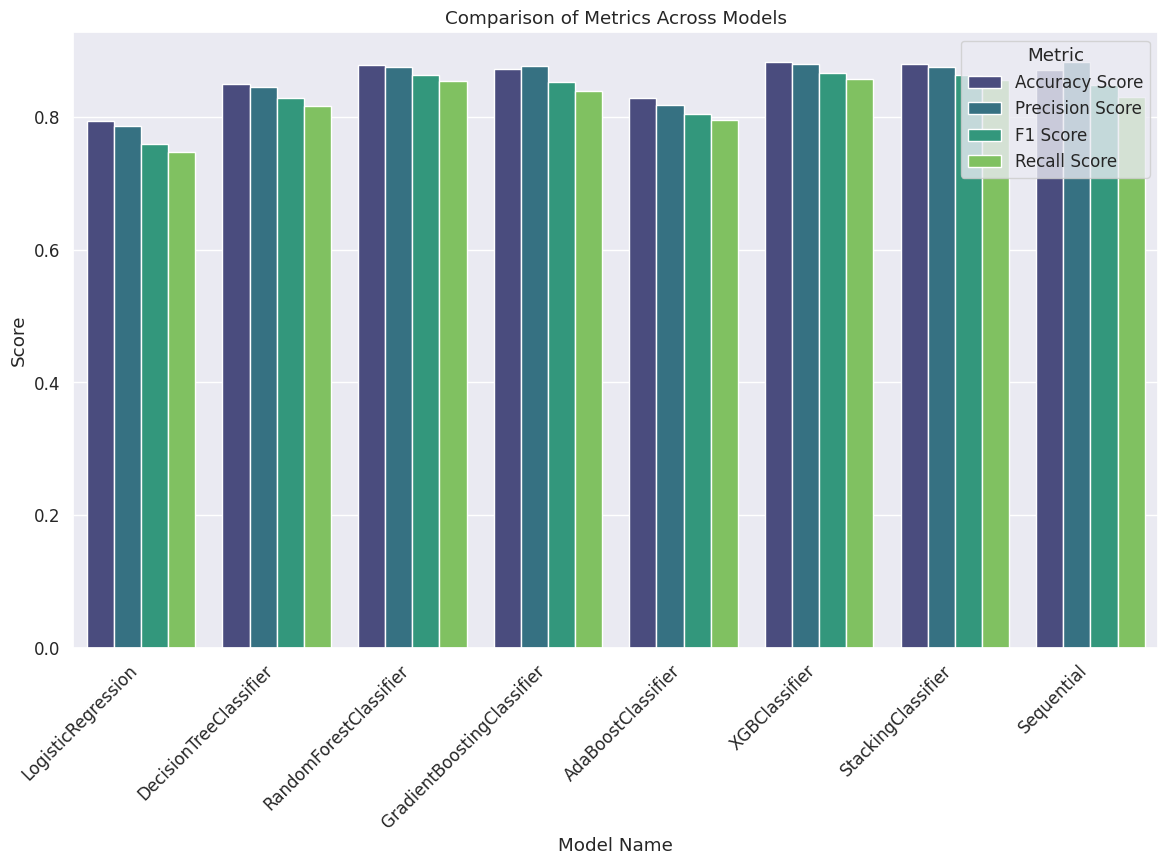

In [30]:
metrics_long:pd.DataFrame = metrics_data.melt(id_vars="Model Name", 
                                  value_vars=["Accuracy Score", "Precision Score", "F1 Score", "Recall Score"],
                                  var_name="Metric", 
                                  value_name="Score")

plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_long, x="Model Name", y="Score", hue="Metric", palette="viridis")
plt.title("Comparison of Metrics Across Models")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.show()

In [31]:
thresholds:List[float] = [0.01, 0.02, 0.05, 0.1, 0.2]

### Plotting ROC Curves for Model Comparison

- **Purpose**: 
  - The code generates and plots ROC curves for all trained models to compare their performance based on the True Positive Rate (TPR) and False Positive Rate (FPR) across various thresholds.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


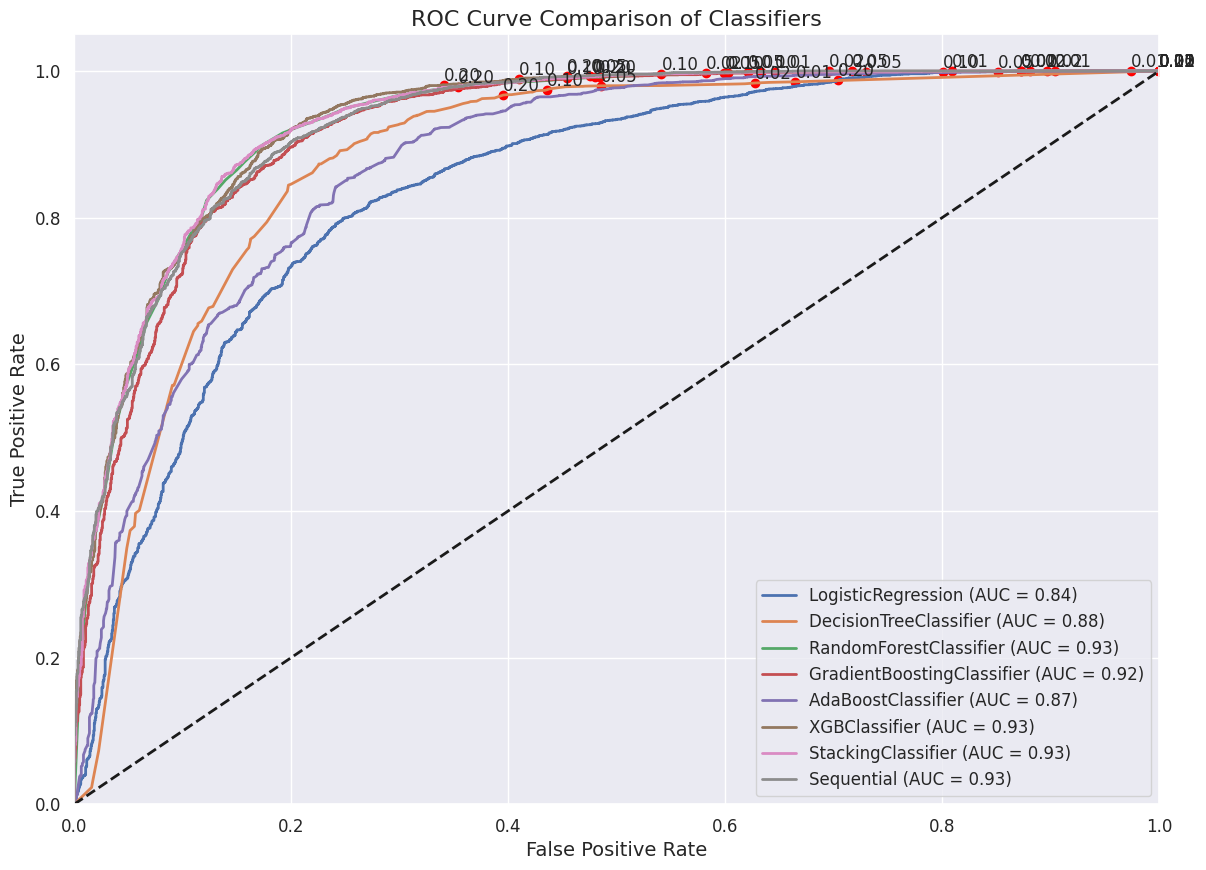

In [32]:
def plot_roc_curves():
    global thresholds
    global models
    plt.figure(figsize=(14, 10))
    x_test_array:np.ndarray = np.array(x_test_scaled)
    
    for model in models:
        if "keras" in str(type(model)).lower():
            preds_proba = model.predict(x_test_array).ravel()
        else:
            preds_proba = model.predict_proba(x_test_scaled)[:, 1]
        
        fpr, tpr, threshold_values = roc_curve(y_test, preds_proba)
        roc_auc:float = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f"{model.__class__.__name__} (AUC = {roc_auc:.2f})")
        
        for threshold in thresholds:
            close_point_idx = np.argmin(np.abs(threshold_values - threshold))
            plt.scatter(fpr[close_point_idx], tpr[close_point_idx], marker='o', color="red")
            plt.text(fpr[close_point_idx], tpr[close_point_idx], f"{threshold:.2f}", fontsize=12, verticalalignment='bottom')
    
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curve Comparison of Classifiers", fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

plot_roc_curves()